# Предсказание стоимости жилья

In [1]:
# сделаем необходимые импорты

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

!pip install pyspark -q
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
    
RANDOM_SEED = 2022

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# инициализация Spark-сессии
spark = SparkSession.builder \
                    .master('local') \
                    .appName('EDA California Housing') \
                    .getOrCreate() 

spark.sparkContext.setLogLevel("ERROR")

In [3]:
# прочитаем файл
housing = spark.read.load('./housing.csv', format='csv', sep=',', inferSchema=True, header="true")

In [4]:
# загрузим схему 
housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
# посмотрим первые строки
housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [6]:
# посмотрим описание данных
housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [7]:
housing.count()

20640

**Вывод**\
В датасете 20640 записей, 10 столбцов.
Один категориальный признак - `ocean_proximity`, означающий удалённость ЖК от океана, остальные признаки числовые.

## Подготовка данных

Изучим данные на пропуски и дубликаты

In [8]:
columns = housing.columns

for column in columns:
    check_col = F.isnan(F.col(column))
    print(column, housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [9]:
for column in columns:
    check_col = F.isnull(F.col(column))
    print(column, housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [10]:
#housing.count() - housing.dropDuplicates(housing.columns).count()

In [11]:
print ('Количество строк всего', housing.count ())
print ('Количество уникальных строк', housing.distinct().count())

Количество строк всего 20640


Количество уникальных строк 20640


Заполним пропуски медианным значением

In [12]:
housing = housing.na.fill(int(housing.approxQuantile('total_bedrooms', [0.5], 0)[0]))

In [13]:
# проверим результат
for column in columns:
    check_col = F.isnull(F.col(column))
    print(column, housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


**Вывод:**
- Дубликатов в данных не обнаружено;
- В столбце `total_bedrooms` обнаружены пропуски и заполнены медианным значением.

## Исследовательский анализ данных

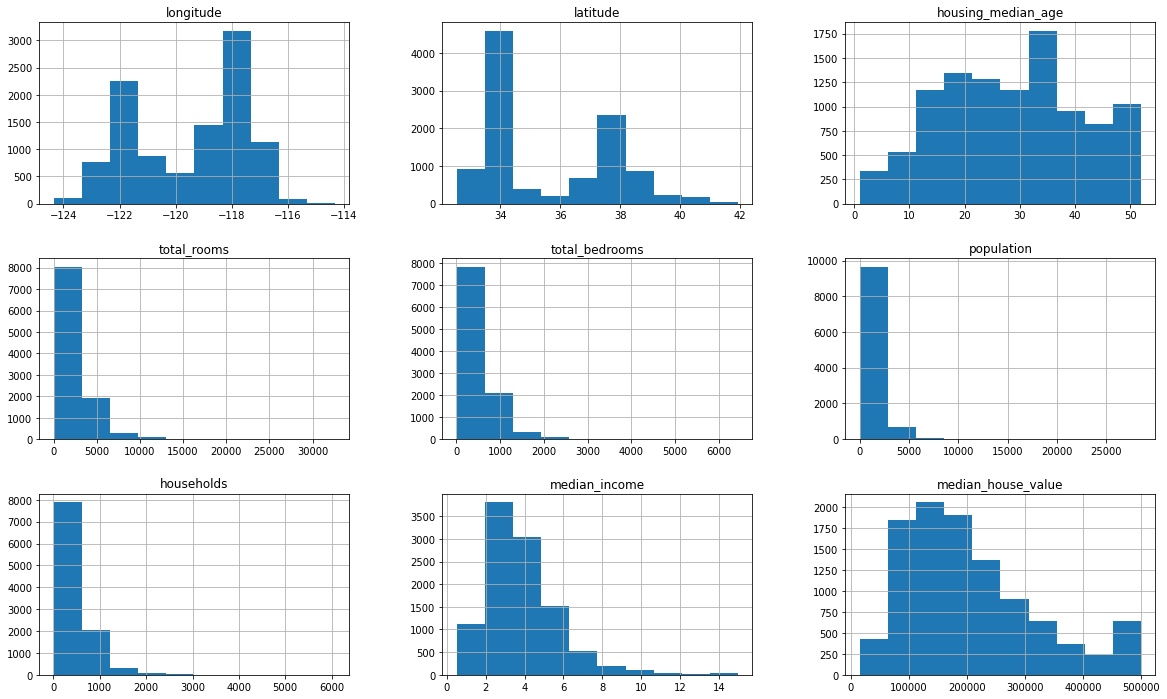

In [14]:
# посмотрим распределение количественных признаков
housing.sample(0.5).toPandas().hist(figsize=(20, 12));

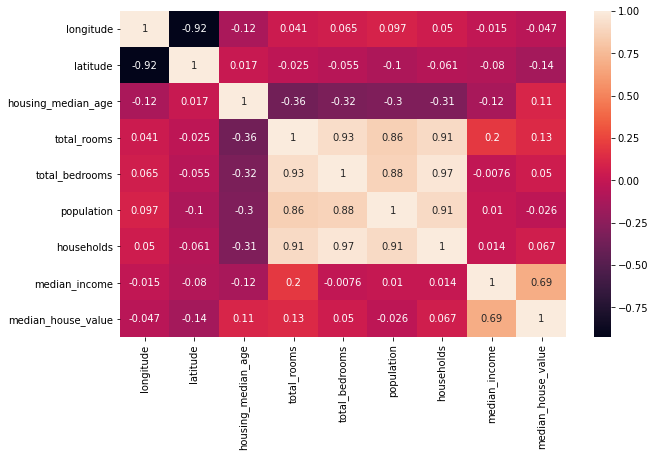

In [15]:
# посмотрим на корреляцию признаков
sns.heatmap(housing.sample(0.5).toPandas().drop(columns=['ocean_proximity']).corr(), annot=True);

Признаки `total_rooms` и `total_bedrooms` сильно коррелируют, также признак `total_bedrooms` не оказывает влияния на целевой, и имеет пропуски. Можем избавиться от этого признака без вреда для результата.

In [16]:
housing = housing.drop('total_bedrooms')

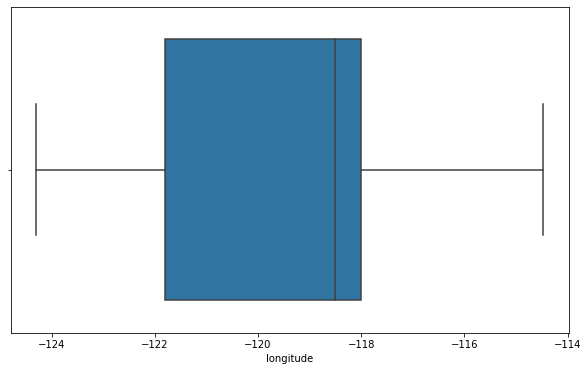

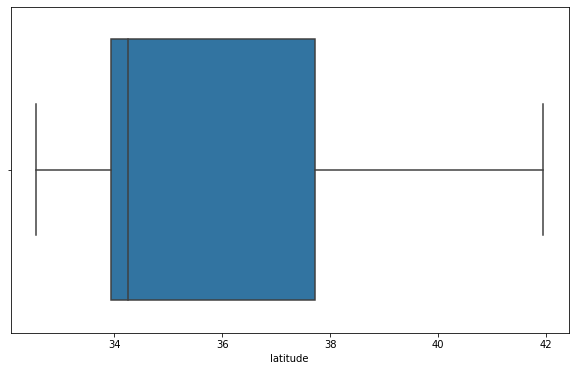

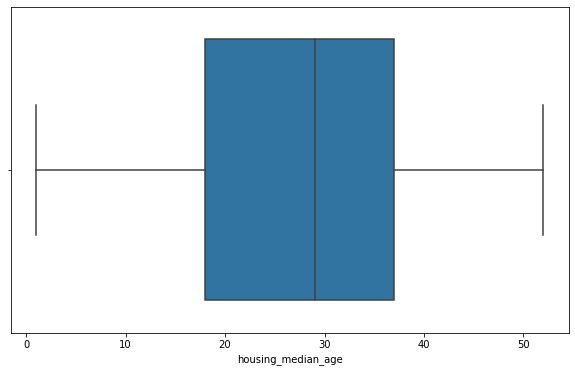

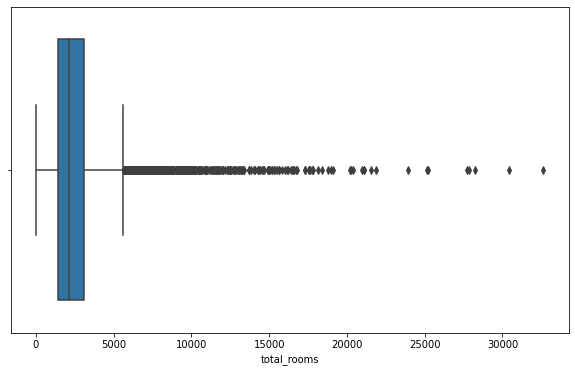

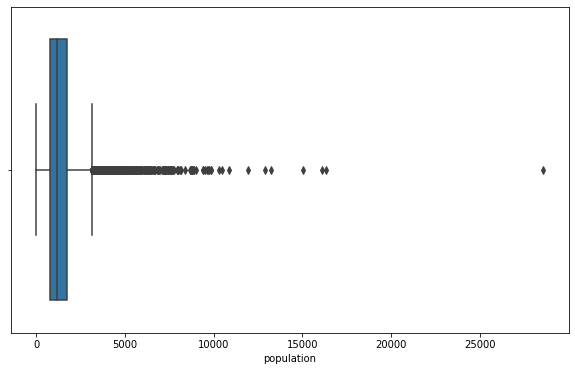

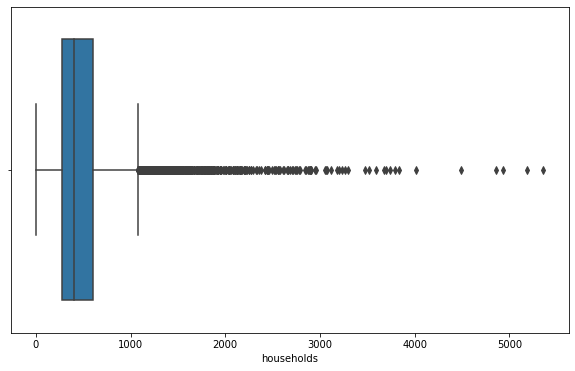

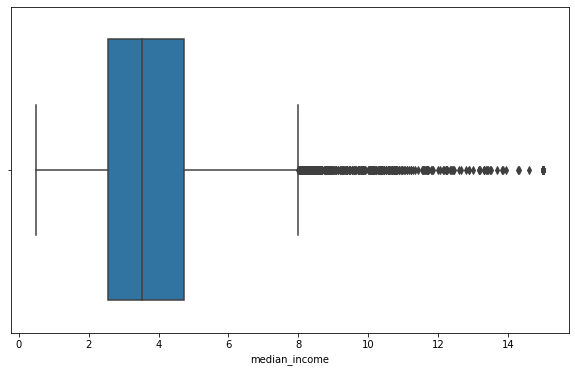

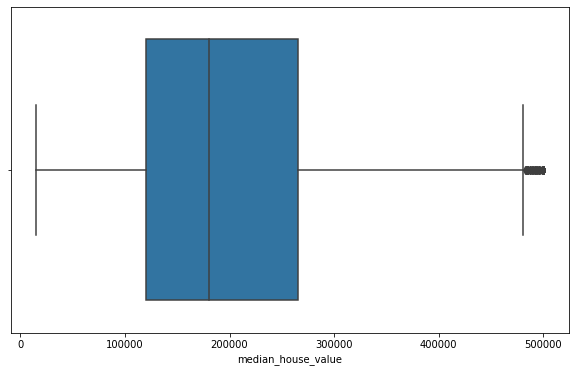

In [17]:
# строим ящики с усами для каждого числового признака
for column in housing.drop('ocean_proximity').sample(0.5).columns:
    sns.boxplot(x=housing.sample(0.5).toPandas()[column])
    plt.show()

В столбцах `total_rooms`, `population`, `households`, `median_income` есть выбросы. Изучим их подробнее.\
Чтобы посмотреть, какой процент от исходного количества данных мы удалили, заведём константную переменную с количеством записей в исходном датасете.

In [18]:
COUNT = 20640

**`total_rooms`**

In [19]:
# описание столбца
housing.select('total_rooms').describe().toPandas()

,summary,total_rooms
0,count,20640
1,mean,2635.7630813953488
2,stddev,2181.6152515827944
3,min,2.0
4,max,39320.0


На графике ящика с усами мы видим, что в нижней границе нет выбросов, они находятся располагаются в верхней границе данных. Такое большое количество выбросов может помешать модели выявить тенденцию, поэтому проведём границу на отметке .99 квантиля, а остальные выбросы удалим.

In [20]:
# найдём значение .99 квантиля
TOTAL_ROOMS_99 = housing.approxQuantile("total_rooms", [0.99], 0)[0]
TOTAL_ROOMS_99

11232.0

In [21]:
# посчитаем процент выбросов, которые собираемся удалить
TOTAL_ROOMS_DELETED = housing.filter(housing.total_rooms > TOTAL_ROOMS_99).count() / COUNT * 100
TOTAL_ROOMS_DELETED

0.9980620155038761

In [22]:
# удаляем выбросы
housing = housing.filter(housing.total_rooms <= TOTAL_ROOMS_99)

**`population`**

In [23]:
# описание столбца
housing.select('population').describe().toPandas()

,summary,population
0,count,20434
1,mean,1366.503817167466
2,stddev,907.725659039993
3,min,3.0
4,max,11272.0


Так жк проведём границу на отметке .99 квантиля, а остальные выбросы удалим.

In [24]:
POPULATION_99 = housing.approxQuantile("population", [0.99], 0)[0]
POPULATION_99

4684.0

In [25]:
POPULATION_DELETED = housing.filter(housing.population > POPULATION_99).count() / COUNT * 100
POPULATION_DELETED

0.9883720930232558

In [26]:
housing = housing.filter(housing.population <= POPULATION_99) 

**`households`**

In [27]:
housing.select('households').describe().toPandas()

,summary,households
0,count,20230
1,mean,467.4309441423628
2,stddev,286.89635543455046
3,min,1.0
4,max,2565.0


In [28]:
HOUSEHOLDS_99 = housing.approxQuantile("households", [0.99], 0)[0]
HOUSEHOLDS_99

1474.0

In [29]:
HOUSEHOLDS_DELETED = housing.filter(housing.households > HOUSEHOLDS_99).count() / COUNT * 100
HOUSEHOLDS_DELETED

0.9738372093023256

In [30]:
housing = housing.filter(housing.households <= HOUSEHOLDS_99) 

**`median_income`**

In [31]:
housing.select('median_income').describe().toPandas()

,summary,median_income
0,count,20029
1,mean,3.863432867342394
2,stddev,1.9065573932749351
3,min,0.4999
4,max,15.0001


In [32]:
MEDIAN_INCOME_99 = housing.approxQuantile("median_income", [0.99], 0)[0]
MEDIAN_INCOME_99

10.6514

In [33]:
MEDIAN_INCOME_DELETED = housing.filter(housing.median_income > MEDIAN_INCOME_99).count() / COUNT * 100
MEDIAN_INCOME_DELETED

0.9689922480620154

In [34]:
housing = housing.filter(housing.median_income <= MEDIAN_INCOME_99) 

In [35]:
DELETED = TOTAL_ROOMS_DELETED + POPULATION_DELETED + HOUSEHOLDS_DELETED + MEDIAN_INCOME_DELETED
DELETED

3.929263565891473

Удаленных записей не так много, около 4%

**Вывод:**
- Удален признак `total_bedrooms`, который почти не влияет на целевой, но коррелирует с признаком `total_rooms`
- Удалены почти 4% выбросов из колонок `total_rooms`, `households`, `median_income` и `population`

## Обучение моделей

In [36]:
# разобьём данные на обучающую и тестовую выборки

train, test = housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train.count(), test.count())

15770 4059


In [37]:
# разделим признаки на категориальные, числовые и целевой

categorical_cols = ["ocean_proximity"]
numerical_cols  = ["longitude", "latitude", "housing_median_age", "total_rooms", "population", "households", "median_income"]
target = "median_house_value"

Сначала трансформируем категориальный признак `ocean_proximity` с помощью трансформера StringIndexer.

In [38]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols])

После этого закодируем его с помощью OneHotEncoding

In [39]:
encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'],
                        outputCols=['ocean_proximity_ohe'])

Приведём числовые признаки к одному масштабу

In [40]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                    outputCol="numerical_features")

In [41]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol="numerical_features_scaled")

Объединеним признаки в один вектор

In [42]:
all_features = ['ocean_proximity_ohe','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

Создадим функцию для обучения моделей

In [43]:
# создаём функцию для обучения модели
def train_func(features):
    
    # создаём объект модели линейной регрессии
    lr = LinearRegression(labelCol=target, featuresCol=features)
    
    # строим сетку для подбора гиперпараметров
    grid_search = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
        .build()
    
    # создаём объект для оценки качества модели метрикой RMSE
    evaluator = RegressionEvaluator(predictionCol='prediction',
                                    labelCol=target)
    
    # строим итоговый пайплайн для обучения модели
    pipeline = Pipeline(
        stages = [indexer, 
                  encoder, 
                  numerical_assembler, 
                  standardScaler, 
                  final_assembler,
                  lr]
    )
    
    # создаём кросс-валидатор
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=grid_search,
                        evaluator=evaluator,
                        numFolds = 5)
    
    # обучаем кросс-валидатор на обучающей выборке
    cv_model = cv.fit(train)
    
    # получаем лучшую модель
    best_model = cv_model.bestModel
    
    # получаем параметры лучшей модели
    params = best_model.stages[5].extractParamMap()
    
    # получаем предсказания на тестовой выборке
    predictions = best_model.transform(test)
    
    return params, predictions

In [44]:
# обучаем модель на полном наборе данных
full_params, full_pred = train_func('features')

In [45]:
full_pred.select('median_house_value', 'prediction').sample(0.5).toPandas().head(10)

,median_house_value,prediction
0,103600.0,147082.011005
1,58100.0,135187.448444
2,68400.0,122235.564448
3,81300.0,148460.392448
4,60000.0,138340.645039
5,74100.0,147878.816700
6,92500.0,168593.206176
7,128100.0,223926.310194
8,99600.0,188585.664153
9,81000.0,160622.283406


In [46]:
# посчитаем метрики

print("RMSE на полном наборе данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(full_pred))
print("R2 на полном наборе данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(full_pred))
print("MAE на полном наборе данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(full_pred))

RMSE на полном наборе данных: 67743.10668969016
R2 на полном наборе данных: 0.643058091392138
MAE на полном наборе данных: 48929.61618482056


В некоторых случаях модель предсказала отрицательный результат. Посмотрим, сколько таких значений получилось.

In [47]:
full_pred.filter(F.col('prediction') < 0).count()

12

In [48]:
full_pred.filter(F.col('prediction') < 0).toPandas()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe,numerical_features,numerical_features_scaled,features,prediction
0,-124.15,41.81,17.0,3276.0,3546.0,585.0,2.2868,103100.0,NEAR OCEAN,2.0,"(0.0, 0.0, 1.0, 0.0)","[-124.15, 41.81, 17.0, 3276.0, 3546.0, 585.0, ...","[-61.79738142534058, 19.48199010055772, 1.3652...","[0.0, 0.0, 1.0, 0.0, -61.79738142534058, 19.48...",-9320.579842
1,-121.79,38.54,7.0,1777.0,4479.0,504.0,1.4653,310000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-121.79, 38.54, 7.0, 1777.0, 4479.0, 504.0, 1...","[-60.622658749836724, 17.95828506279585, 0.562...","[0.0, 1.0, 0.0, 0.0, -60.622658749836724, 17.9...",-148822.837160
2,-120.51,40.41,36.0,36.0,4198.0,7.0,5.5179,67500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.51, 40.41, 36.0, 36.0, 4198.0, 7.0, 5.5179]","[-59.98552102752954, 18.82963931986456, 2.8911...","[0.0, 1.0, 0.0, 0.0, -59.98552102752954, 18.82...",-114008.063171
3,-120.09,39.92,19.0,2335.0,1028.0,383.0,1.7267,60700.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.09, 39.92, 19.0, 2335.0, 1028.0, 383.0, ...","[-59.7764602123975, 18.601316546621963, 1.5258...","[0.0, 1.0, 0.0, 0.0, -59.7764602123975, 18.601...",-4405.362463
4,-120.08,41.79,34.0,1355.0,434.0,178.0,2.0903,56100.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.08, 41.79, 34.0, 1355.0, 434.0, 178.0, 2...","[-59.771482573941974, 19.472670803690676, 2.73...","[0.0, 1.0, 0.0, 0.0, -59.771482573941974, 19.4...",-21247.792849
5,-120.06,39.15,22.0,2213.0,98.0,42.0,1.1912,170000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-120.06, 39.15, 22.0, 2213.0, 98.0, 42.0, 1.1...","[-59.76152729703093, 18.242523617240725, 1.766...","[0.0, 1.0, 0.0, 0.0, -59.76152729703093, 18.24...",-21182.882867
6,-119.75,36.72,22.0,3247.0,4179.0,881.0,1.3343,60800.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-119.75, 36.72, 22.0, 3247.0, 4179.0, 881.0, ...","[-59.607220504909655, 17.110229047894748, 1.76...","[0.0, 1.0, 0.0, 0.0, -59.607220504909655, 17.1...",-46015.725993
7,-119.28,36.33,10.0,1051.0,927.0,274.0,0.7800,55500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-119.28, 36.33, 10.0, 1051.0, 927.0, 274.0, 0...","[-59.37327149749999, 16.92850275898737, 0.8030...","[0.0, 1.0, 0.0, 0.0, -59.37327149749999, 16.92...",-390.229504
8,-114.68,33.49,20.0,1491.0,1135.0,303.0,1.6395,44400.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-114.68, 33.49, 20.0, 1491.0, 1135.0, 303.0, ...","[-57.08355780795858, 15.60516260386697, 1.6061...","[0.0, 1.0, 0.0, 0.0, -57.08355780795858, 15.60...",-8480.643708
9,-114.65,32.79,21.0,44.0,64.0,27.0,0.8571,25000.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)","[-114.65, 32.79, 21.0, 44.0, 64.0, 27.0, 0.8571]","[-57.068624892592005, 15.278987213520393, 1.68...","[0.0, 1.0, 0.0, 0.0, -57.068624892592005, 15.2...",-10054.158048


Можно заметить, что у этих записей возраст здания небольшой, медианный доход на жителя ниже среднего, и почти все удалены от океана. Возможно, совокупность этих признаков даёт такой результат. В некоторых записях могут быть аномалии, к примеру, где на 7 домовладений приходится 4198 человек.

Обучим модель только на числовых признаках.

In [49]:
# произведем изменения в пайплайне, перепишем функцию

def train_func_2(features):
    
    # создаём объект модели линейной регрессии
    lr = LinearRegression(labelCol=target, featuresCol=features)
    
    # строим сетку для подбора гиперпараметров
    grid_search = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
        .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
        .build()
    
    # создаём объект для оценки качества модели метрикой RMSE
    evaluator = RegressionEvaluator(predictionCol='prediction',
                                    labelCol=target)
    
    # строим итоговый пайплайн для обучения модели
    pipeline = Pipeline(
        stages = [numerical_assembler, 
                  standardScaler, 
                  lr]
    )
    
    # создаём кросс-валидатор
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=grid_search,
                        evaluator=evaluator,
                        numFolds = 5)
    
    # обучаем кросс-валидатор на обучающей выборке
    cv_model = cv.fit(train)
    
    # получаем лучшую модель
    best_model = cv_model.bestModel
    
    # получаем параметры лучшей модели
    params = best_model.stages[2].extractParamMap()
    
    # получаем предсказания на тестовой выборке
    predictions = best_model.transform(test)
    
    return params, predictions

In [50]:
num_params, num_pred = train_func_2('numerical_features_scaled')

In [51]:
num_pred.select('median_house_value', 'prediction').sample(0.5).toPandas().head(10)

,median_house_value,prediction
0,58100.0,104780.091899
1,68400.0,74317.491023
2,67000.0,113650.821620
3,81300.0,117096.870895
4,70500.0,136323.293552
5,60000.0,108475.081375
6,74100.0,118052.932089
7,90000.0,183762.933219
8,104200.0,170115.637194
9,74100.0,125860.448426


In [52]:
# посчитаем метрики

print("RMSE на числовых данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(num_pred))
print("R2 на числовых данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(num_pred))
print("MAE на числовых данных:", 
      RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(num_pred))

RMSE на числовых данных: 68591.96244763942
R2 на числовых данных: 0.634056717442276
MAE на числовых данных: 49972.280273974866


In [53]:
num_pred.filter(F.col('prediction') < 0).count()

24

In [54]:
num_pred.filter(F.col('prediction') < 0).toPandas()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,numerical_features_scaled,prediction
0,-124.15,41.81,17.0,3276.0,3546.0,585.0,2.2868,103100.0,NEAR OCEAN,"[-124.15, 41.81, 17.0, 3276.0, 3546.0, 585.0, ...","[-61.79738142534058, 19.48199010055772, 1.3652...",-61586.447882
1,-122.26,37.87,52.0,1087.0,3337.0,350.0,1.4012,175000.0,NEAR BAY,"[-122.26, 37.87, 52.0, 1087.0, 3337.0, 350.0, ...","[-60.85660775724639, 17.64608861774984, 4.1760...",-3633.967619
2,-122.26,41.66,17.0,1885.0,953.0,328.0,2.1607,61400.0,INLAND,"[-122.26, 41.66, 17.0, 1885.0, 953.0, 328.0, 2...","[-60.85660775724639, 19.41209537405488, 1.3652...",-17087.884825
3,-121.93,41.86,28.0,4225.0,1908.0,686.0,1.7400,44000.0,INLAND,"[-121.93, 41.86, 28.0, 4225.0, 1908.0, 686.0, ...","[-60.69234568821407, 19.505288342725333, 2.248...",-34300.768550
4,-121.79,38.54,7.0,1777.0,4479.0,504.0,1.4653,310000.0,INLAND,"[-121.79, 38.54, 7.0, 1777.0, 4479.0, 504.0, 1...","[-60.622658749836724, 17.95828506279585, 0.562...",-142712.301351
5,-121.67,40.61,8.0,2411.0,786.0,297.0,2.1513,80400.0,INLAND,"[-121.67, 40.61, 8.0, 2411.0, 786.0, 297.0, 2....","[-60.56292708837042, 18.922832288535016, 0.642...",-8970.936947
6,-121.11,41.07,26.0,1707.0,761.0,250.0,2.7188,48100.0,INLAND,"[-121.11, 41.07, 26.0, 1707.0, 761.0, 250.0, 2...","[-60.28417933486103, 19.137176116477054, 2.088...",-9854.044465
7,-120.96,41.12,29.0,779.0,364.0,123.0,2.5000,59200.0,INLAND,"[-120.96, 41.12, 29.0, 779.0, 364.0, 123.0, 2.5]","[-60.209514758028156, 19.160474358644663, 2.32...",-21943.471214
8,-120.74,39.39,18.0,453.0,152.0,77.0,1.3523,85700.0,INLAND,"[-120.74, 39.39, 18.0, 453.0, 152.0, 77.0, 1.3...","[-60.10000671200661, 18.354355179645268, 1.445...",-17518.547902
9,-120.51,40.41,36.0,36.0,4198.0,7.0,5.5179,67500.0,INLAND,"[-120.51, 40.41, 36.0, 36.0, 4198.0, 7.0, 5.5179]","[-59.98552102752954, 18.82963931986456, 2.8911...",-154095.069813


При обучении модели только на числовых данных мы видим увеличение количества отрицательных значений, но их по-прежнему не критично много, и здесь те же закономерности, что и в первом случае. 

In [55]:
# завершаем сессию

spark.stop()

## Анализ результатов

По результатм работы двух моделей лучшей оказалась модель, в которой использованы и категориальные и числовые признаки: у нее минимальные **RMSE = 67743** и **MAE = 48930** и выше **R-squared = 0.643**. Чуть более низкими результатами обладает модель только с числовыми признаками, без категориальных.